In [1]:
import sys
import pickle as pkl
import torch

from tqdm import tqdm

sys.path.append("../../utils")

from surface_analyzer import *
from utils import *
from pymatgen.analysis.local_env import *

test_targets = pkl.load(open('test_targs3.pkl','rb'))
test_preds = pkl.load(open('test_preds3.pkl','rb'))
test_ids = pkl.load(open('test_ids3.pkl','rb'))


bulk_data = pkl.load(open('../data_raw/bulk_dos_newref.pkl','rb'))


In [2]:
len(bulk_data)*0.6

12523.8

In [3]:
jc = JobConfig.objects.get(name='pbe_u_paw_spinpol_opt_surf_vasp')
my_surfaces = Surface.objects.filter(parentjob__config=jc, converged=True)

jc = JobConfig.objects.get(name='pbe_u_paw_spinpol_opt_surf_vasp')
my_bulk = Crystal.objects.filter(parentjob__config=jc, converged=True)

In [4]:
def get_metal_sites(bulk):

    atomic_numbers = np.array(bulk.xyz)[:,0].tolist()
    atomic_symbols = [Element.from_Z(z).symbol for z in atomic_numbers]
    return np.where([symbol!='O' for symbol in atomic_symbols])[0]


In [5]:
def get_oxygen_sites(bulk):

    atomic_numbers = np.array(bulk.xyz)[:,0].tolist()
    atomic_symbols = [Element.from_Z(z).symbol for z in atomic_numbers]
    return np.where([symbol=='O' for symbol in atomic_symbols])[0]

In [ ]:
# only surface metal atoms

bandcenter_dict = {}

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        bulk = Crystal.objects.get(id=id_)
    except:
        pass
    else:
            
        M_sites = get_metal_sites(bulk)

        # magmoms
        targ = np.array(test_targets[index])[:,1]#.numpy()
        pred = np.array(test_preds[index])[:,1]#.numpy()

        site_targs.append(np.array(targ)[M_sites])
        site_preds.append(np.array(pred)[M_sites])
        
        atomic_numbers = np.array(bulk.xyz)[:,0].tolist()
        atomic_symbols = np.array([Element.from_Z(z).symbol for z in atomic_numbers])[M_sites]
        for i in range(len(atomic_symbols)):
            symbol = atomic_symbols[i]
            if symbol in bandcenter_dict.keys():
                array = bandcenter_dict[symbol]
                array.append(targ[i])
                bandcenter_dict.update({symbol:array})
            else:
                bandcenter_dict.update({symbol:[targ[i]]})
        
        

site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]
_, _, ax, _ = plot_hexbin(np.array(site_targs)[indexes], np.array(site_preds)[indexes], 'magmom', bins='log', cmap='gray_r')

plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.savefig('parity_dband_bulk.pdf')

plt.show()



In [ ]:
# only surface metal atoms

#bandcenter_dict = {}

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        bulk = Crystal.objects.get(id=id_)
    except:
        pass
    else:
            
        M_sites = get_metal_sites(bulk)

        # magmoms
        targ = np.array(test_targets[index])[:,1]#.numpy()

        site_targs.append(np.array(targ)[M_sites])
        
        atomic_numbers = np.array(bulk.xyz)[:,0].tolist()
        atomic_symbols = np.array([Element.from_Z(z).symbol for z in atomic_numbers])[M_sites]
        
        pred=[]
        for symbol in atomic_symbols:
            pred.append(np.mean(bandcenter_dict[symbol]))
            
        site_preds.append(pred)
  

site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]
_, _, ax, _ = plot_hexbin(np.array(site_targs)[indexes], np.array(site_preds)[indexes], 'magmom', bins='log', cmap='gray_r')

plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.show()




In [ ]:
import pickle as pkl
fit_values = pkl.load(open('fit_values_bandcenter.pkl','rb'))

In [ ]:
fit_values.keys()

In [ ]:
# need to fit Ro values for every pairing
cn = CrystalNN()

# matching the symbol set to y (np.log(-bandcenter/n)) and x (Rij)
symbol_set_bandcenter = {}   
symbol_set_rij = {}
symbol_set_n = {}

count = 0

x = []
y = []

i = 0

for dat in tqdm(test_ids):
    
    struct = bulk_data[dat]
    
    bulk = Crystal.objects.get(id=dat)
    M_sites = get_metal_sites(bulk)
    
    for index in M_sites:
        
        site1 = struct.sites[index]
        symbol1 = list(site1.species.as_dict().keys())[0]
        
        bandcenter = struct.site_properties['bandcenter'][index]
        
        # get symbol set for the given site
        symbol_set_site = []
        neighbors = cn.get_nn_info(struct, index)
        
        dist = []
        for n in neighbors:
            site2 = n['site']
            symbol2 = list(site2.species.as_dict().keys())[0]
            symbol_set_site.append(symbol1+symbol2)
            dist.append(site2.distance(site1))
            
        n = len(dist)
        d = np.mean(dist)
        
        # check that there's only one type of interaction for this site
        pred=0
        for i in range(len(dist)):
            
            symbol = symbol_set_site[i]
            
            if symbol in fit_values.keys():
                
                Ro = fit_values[symbol]['Ro']
                b = fit_values[symbol]['b']
                pred+=exp((Ro-dist[i])/b)
                    
            else:
                pred+=np.nan
                 
        x.append(pred)
        y.append(bandcenter)
            

site_targs = y
site_preds = x



indexes_finite = np.where(np.isfinite(np.array(site_preds)))[0]
indexes_no_nan = np.where(~np.isnan(np.array(site_preds)))[0]
indexes = np.intersect1d(indexes_finite, indexes_no_nan)

site_targs = np.array(site_targs)[indexes]
site_preds = np.array(site_preds)[indexes]

        
_, _, ax, _ = plot_hexbin(site_targs, -1*site_preds, 'magmom', bins='log', cmap='gray_r')


plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.show()





In [ ]:
# only surface metal atoms

bandcenter_dict = {}

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        bulk = Crystal.objects.get(id=id_)
    except:
        pass
    else:
            
        M_sites = get_oxygen_sites(bulk)

        # magmoms
        targ = np.array(test_targets[index])[:,1]#.numpy()
        pred = np.array(test_preds[index])[:,1]#.numpy()

        site_targs.append(np.array(targ)[M_sites])
        site_preds.append(np.array(pred)[M_sites])
        
        atomic_numbers = np.array(bulk.xyz)[:,0].tolist()
        atomic_symbols = np.array([Element.from_Z(z).symbol for z in atomic_numbers])[M_sites]
        for i in range(len(atomic_symbols)):
            symbol = atomic_symbols[i]
            if symbol in bandcenter_dict.keys():
                array = bandcenter_dict[symbol]
                array.append(targ[i])
                bandcenter_dict.update({symbol:array})
            else:
                bandcenter_dict.update({symbol:[targ[i]]})
        
        

site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]
_, _, ax, _ = plot_hexbin(np.array(site_targs)[indexes], np.array(site_preds)[indexes], 'magmom', bins='log', cmap='gray_r')

plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.savefig('parity_dband_bulk.pdf')

plt.show()




In [ ]:
# need to fit Ro values for every pairing
cn = CrystalNN()

# matching the symbol set to y (np.log(-bandcenter/n)) and x (Rij)
symbol_set_bandcenter = {}   
symbol_set_rij = {}
symbol_set_n = {}

count = 0

x = []
y = []

i = 0

for dat in tqdm(test_ids):
    
    struct = bulk_data[dat]
    
    bulk = Crystal.objects.get(id=dat)
    M_sites = get_oxygen_sites(bulk)
    
    for index in M_sites:
        
        site1 = struct.sites[index]
        symbol1 = list(site1.species.as_dict().keys())[0]
        
        bandcenter = struct.site_properties['bandcenter'][index]
        
        # get symbol set for the given site
        symbol_set_site = []
        neighbors = cn.get_nn_info(struct, index)
        
        dist = []
        for n in neighbors:
            site2 = n['site']
            symbol2 = list(site2.species.as_dict().keys())[0]
            symbol_set_site.append(symbol1+symbol2)
            dist.append(site2.distance(site1))
            
        n = len(dist)
        d = np.mean(dist)
        
        # check that there's only one type of interaction for this site
        pred=0
        for i in range(len(dist)):
            
            symbol = symbol_set_site[i]
            
            if symbol in fit_values.keys():
                
                Ro = fit_values[symbol]['Ro']
                b = fit_values[symbol]['b']
                pred+=exp((Ro-dist[i])/b)
                    
            else:
                pred+=np.nan
                 
        x.append(pred)
        y.append(bandcenter)
            

site_targs = y
site_preds = x



indexes_finite = np.where(np.isfinite(np.array(site_preds)))[0]
indexes_no_nan = np.where(~np.isnan(np.array(site_preds)))[0]
indexes = np.intersect1d(indexes_finite, indexes_no_nan)

site_targs = np.array(site_targs)[indexes]
site_preds = np.array(site_preds)[indexes]

        
_, _, ax, _ = plot_hexbin(site_targs, -1*site_preds, 'magmom', bins='log', cmap='gray_r')


plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.show()






100%|██████████| 2088/2088 [00:03<00:00, 608.04it/s]


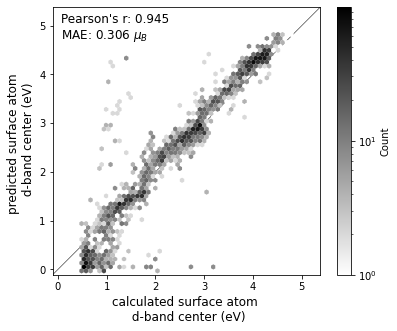

In [11]:
# only surface metal atoms

bandcenter_dict = {}

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        bulk = Crystal.objects.get(id=id_)
    except:
        pass
    else:

        # magmoms
        targ = np.array(test_targets[index])[:,0]#.numpy()
        pred = np.array(test_preds[index])[:,0]#.numpy()

        site_targs.append(np.array(targ))
        site_preds.append(np.array(pred))
        
        
        atomic_numbers = np.array(bulk.xyz)[:,0].tolist()
        atomic_symbols = np.array([Element.from_Z(z).symbol for z in atomic_numbers])
        for i in range(len(atomic_symbols)):
            symbol = atomic_symbols[i]
            if symbol in bandcenter_dict.keys():
                array = bandcenter_dict[symbol]
                array.append(targ[i])
                bandcenter_dict.update({symbol:array})
            else:
                bandcenter_dict.update({symbol:[targ[i]]})
    

site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]

site_targs_nonzero = []
site_preds_nonzero = []

for i in indexes:
    if site_targs[i] > 0.5 and site_targs[i] < 5.0:
        site_targs_nonzero.append(site_targs[i])
        site_preds_nonzero.append(site_preds[i])
    
_, _, ax, _ = plot_hexbin(site_targs_nonzero, site_preds_nonzero, 'magmom', bins='log', cmap='gray_r')

plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.savefig('parity_magmom_bulk.pdf')

plt.show()




100%|██████████| 2088/2088 [01:33<00:00, 22.43it/s]


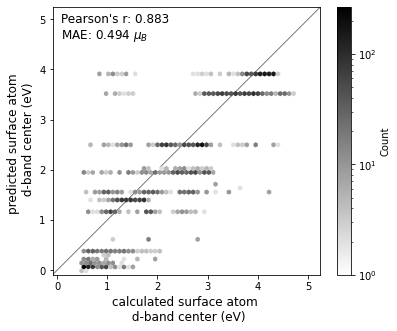

In [17]:
# only surface metal atoms

#bandcenter_dict = {}

site_targs = []
site_preds = []

for index in tqdm(range(len(test_ids))):
    

    id_ = test_ids[index]
    
    try:
        bulk = Crystal.objects.get(id=id_)
    except:
        pass
    else:


        # magmoms
        targ = np.array(test_targets[index])[:,0]#.numpy()
        pred = np.array(test_preds[index])[:,0]#.numpy()

        site_targs.append(np.array(targ))
        
        atomic_numbers = np.array(bulk.xyz)[:,0].tolist()
        atomic_symbols = np.array([Element.from_Z(z).symbol for z in atomic_numbers])
        
        pred=[]
        for symbol in atomic_symbols:
            
            x = np.array(bandcenter_dict[symbol])
            x = x[~np.isnan(x)]
            pred.append(np.mean(x))
            
        site_preds.append(pred)
  

site_targs = flatten(site_targs)
site_preds = flatten(site_preds)

indexes = np.where(~np.isnan(np.array(site_targs)))[0]

site_targs_nonzero = []
site_preds_nonzero = []

for i in indexes:
    if site_targs[i] > 0.5 and site_targs[i] < 5.0:
        site_targs_nonzero.append(site_targs[i])
        site_preds_nonzero.append(site_preds[i])
        
_, _, ax, _ = plot_hexbin(site_targs_nonzero, site_preds_nonzero, 'magmom', bins='log', cmap='gray_r')


plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.show()





/home/lungerja/anaconda3/envs/arpae/lib/python3.9/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


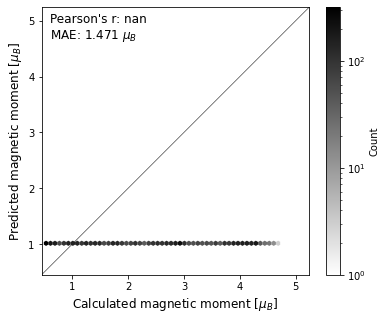

In [26]:
_, _, ax, _ = plot_hexbin(site_targs_nonzero, np.ones(len(site_targs_nonzero)), 'magmom', bins='log', cmap='gray_r')



In [13]:
fit_values

{'CoO': {'Ro': 5.091661948482724, 'b': -3.23713825149722},
 'NiO': {'Ro': 3.336327840041732, 'b': -0.9719844844445379},
 'CrO': {'Ro': 3.0668094608799166, 'b': -1.2573962716922116},
 'VO': {'Ro': 3.3132116483342684, 'b': -0.9370360286635682},
 'MnO': {'Ro': 2.970232434644885, 'b': -1.892480568433492},
 'OCu': {'Ro': 1.601727343643781, 'b': 0.24199392128397745},
 'MoO': {'Ro': 3.3442870793483688, 'b': -1.0650816681892183},
 'OCo': {'Ro': 1.4896516917830374, 'b': 0.3597563813153454},
 'OsO': {'Ro': 2.3042859847668464, 'b': -0.2166949803103739},
 'FeO': {'Ro': -0.7257683679193798, 'b': 6.738218305687203},
 'TiO': {'Ro': -13.636315426596985, 'b': 8.056249240439943},
 'OSc': {'Ro': 1.4109929534749597, 'b': 0.5694926996205008},
 'OSr': {'Ro': 1.3263999897391368, 'b': 1.665753954529458},
 'OMg': {'Ro': 2.377613828069976, 'b': -0.4325465893969537},
 'OZn': {'Ro': 1.6832344726083717, 'b': 0.5213414967400691},
 'RuO': {'Ro': 15.10462542960642, 'b': -7.471585938127052},
 'OLi': {'Ro': 12.75017401

  0%|          | 0/100 [00:00<?, ?it/s]/home/lungerja/anaconda3/envs/arpae/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:4121: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/lungerja/anaconda3/envs/arpae/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:3924: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


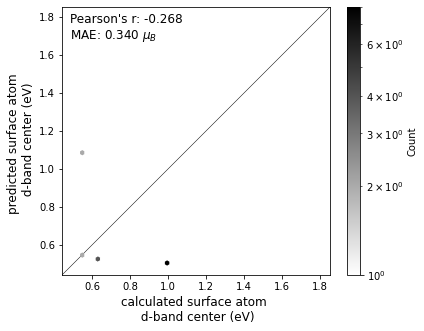

In [28]:
# need to fit Ro values for every pairing
fit_values = pkl.load(open('fit_values_magmom.pkl','rb'))
cn = CrystalNN()

# matching the symbol set to y (np.log(-magmom/n)) and x (Rij)
symbol_set_magmom = {}   
symbol_set_rij = {}
symbol_set_n = {}

count = 0

x = []
y = []

i = 0

for dat in tqdm(test_ids[0:100]):
    
    struct = bulk_data[dat]
    
    bulk = Crystal.objects.get(id=dat)
    M_sites = get_oxygen_sites(bulk)
    
    for index in M_sites:
        
        site1 = struct.sites[index]
        symbol1 = list(site1.species.as_dict().keys())[0]
        
        if 'magmom' in struct.site_properties.keys():
            magmom = struct.site_properties['magmom'][index]
        
            # get symbol set for the given site
            symbol_set_site = []
            neighbors = cn.get_nn_info(struct, index)
        
            dist = []
            for n in neighbors:
                site2 = n['site']
                symbol2 = list(site2.species.as_dict().keys())[0]
                symbol_set_site.append(symbol1+symbol2)
                dist.append(site2.distance(site1))
            
            n = len(dist)
            d = np.mean(dist)
        
            # check that there's only one type of interaction for this site
            pred=0
            for i in range(len(dist)):
            
                symbol = symbol_set_site[i]
            
                if symbol in fit_values.keys():
                
                    try:
                        Ro = fit_values[symbol]['Ro']
                        b = fit_values[symbol]['b']
                        pred+=exp((Ro-dist[i])/b)
                    except:
                        pred+=np.nan
                    
                else:
                    pred+=np.nan
                 
            x.append(pred)
            y.append(magmom)
            

site_targs = y
site_preds = x



indexes_finite = np.where(np.isfinite(np.array(site_preds)))[0]
indexes_no_nan = np.where(~np.isnan(np.array(site_preds)))[0]
indexes = np.intersect1d(indexes_finite, indexes_no_nan)

site_targs = np.array(site_targs)[indexes]
site_preds = np.array(site_preds)[indexes]

        
site_targs_nonzero = []
site_preds_nonzero = []

for i in range(len(site_targs)):
    if site_targs[i] > 0.5 and site_targs[i] < 5.0:
        site_targs_nonzero.append(site_targs[i])
        site_preds_nonzero.append(site_preds[i])
        
_, _, ax, _ = plot_hexbin(site_targs_nonzero, site_preds_nonzero, 'magmom', bins='log', cmap='gray_r')


plt.xlabel('calculated surface atom \n d-band center (eV)')
plt.ylabel('predicted surface atom \n d-band center (eV)')

plt.show()









In [ ]:
plt.scatter(site_targs_nonzero, site_preds_nonzero)

In [ ]:
plt.scatter(site_targs, site_preds)

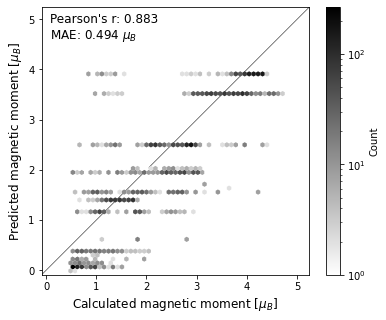

In [15]:
_, _, ax, _ = plot_hexbin(site_targs_nonzero, site_preds_nonzero, 'magmom', bins='log', cmap='gray_r')

